In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, log_loss, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from sklearn import config_context



from mlxtend.plotting import plot_decision_regions

from itertools import product

from imblearn.over_sampling import SMOTE


import xgboost as xgb
from xgboost import XGBClassifier


In [10]:
df = pd.read_csv("../BankC_Clean.csv")


In [11]:
def permutations(dataset):
    X = dataset.drop(columns=['income'])
    y = dataset['income']


    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    perm_importance = permutation_importance(
        model, X, y,
        scoring='accuracy',
        n_repeats=3,
        random_state=42,
        n_jobs=-1
    )

    sorted_idx = np.argsort(perm_importance.importances_mean)[-10:]

    plt.figure(figsize=(10, 6))
    plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title("Top 10 Features - Permutation Importance")
    plt.tight_layout()
    plt.show()


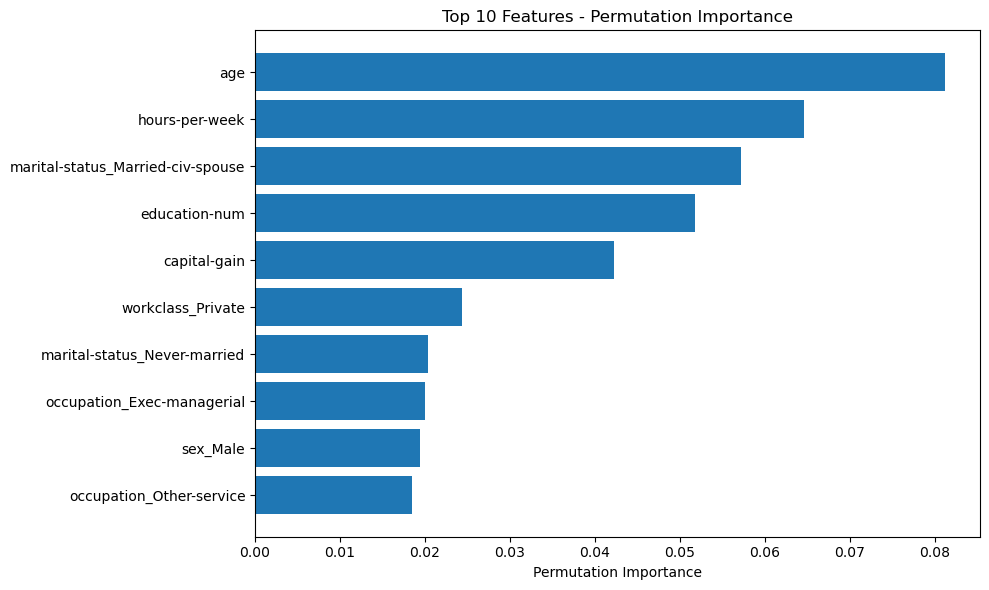

In [12]:
permutations(df)

In [13]:
X = df.drop(columns=["income"])
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88     28433
         1.0       0.47      0.87      0.61      5691

    accuracy                           0.82     34124
   macro avg       0.72      0.84      0.74     34124
weighted avg       0.88      0.82      0.83     34124



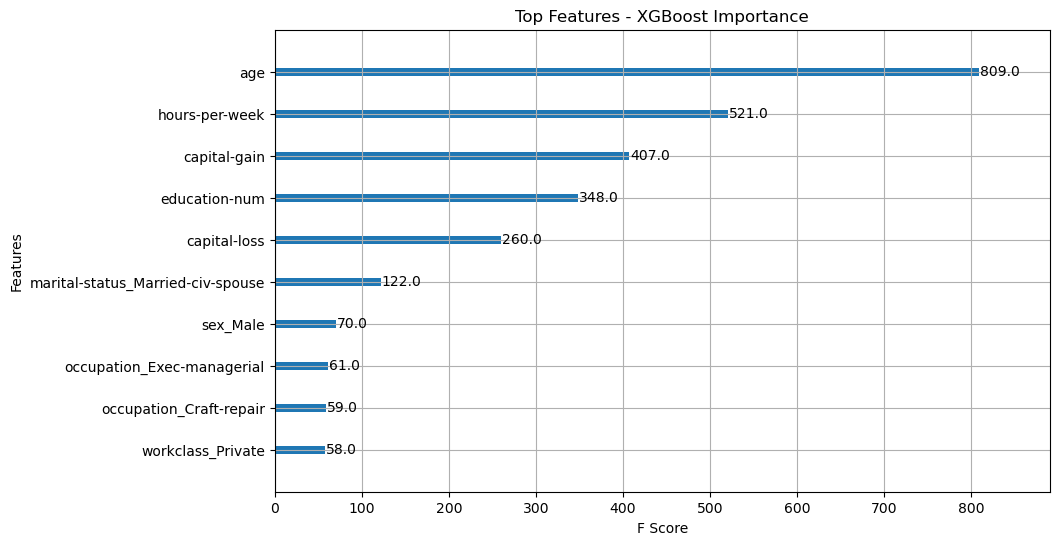

In [15]:
model = xgb.XGBClassifier(scale_pos_weight=5.5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax, max_num_features=10)
ax.set_title("Top Features - XGBoost Importance")
ax.set_xlabel("F Score")
ax.set_ylabel("Features")
plt.show()

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     28291
         1.0       0.77      0.54      0.63      5833

    accuracy                           0.89     34124
   macro avg       0.84      0.75      0.78     34124
weighted avg       0.89      0.89      0.89     34124



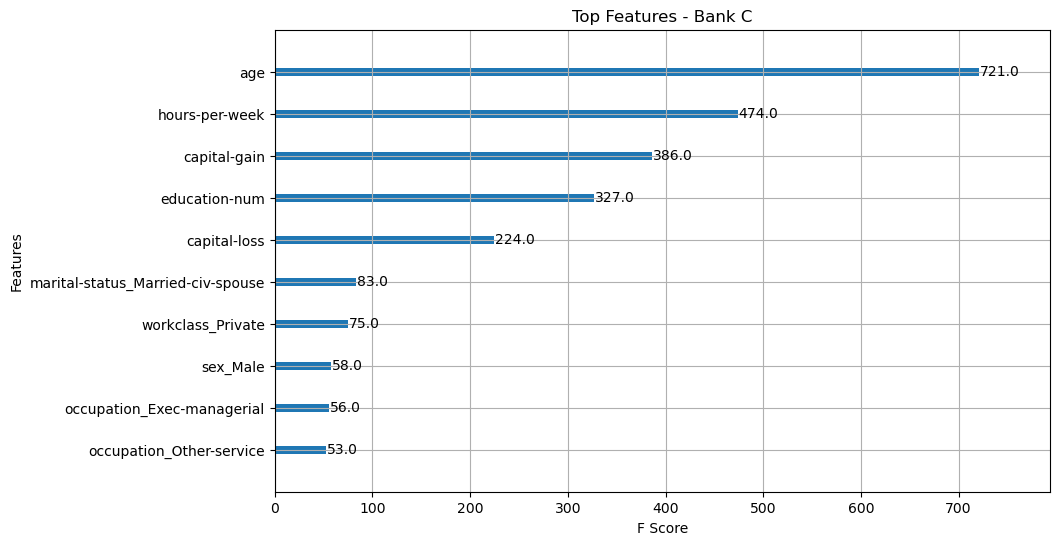

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax, max_num_features=10)
ax.set_title("Top Features - Bank C")
ax.set_xlabel("F Score")
ax.set_ylabel("Features")
plt.show()


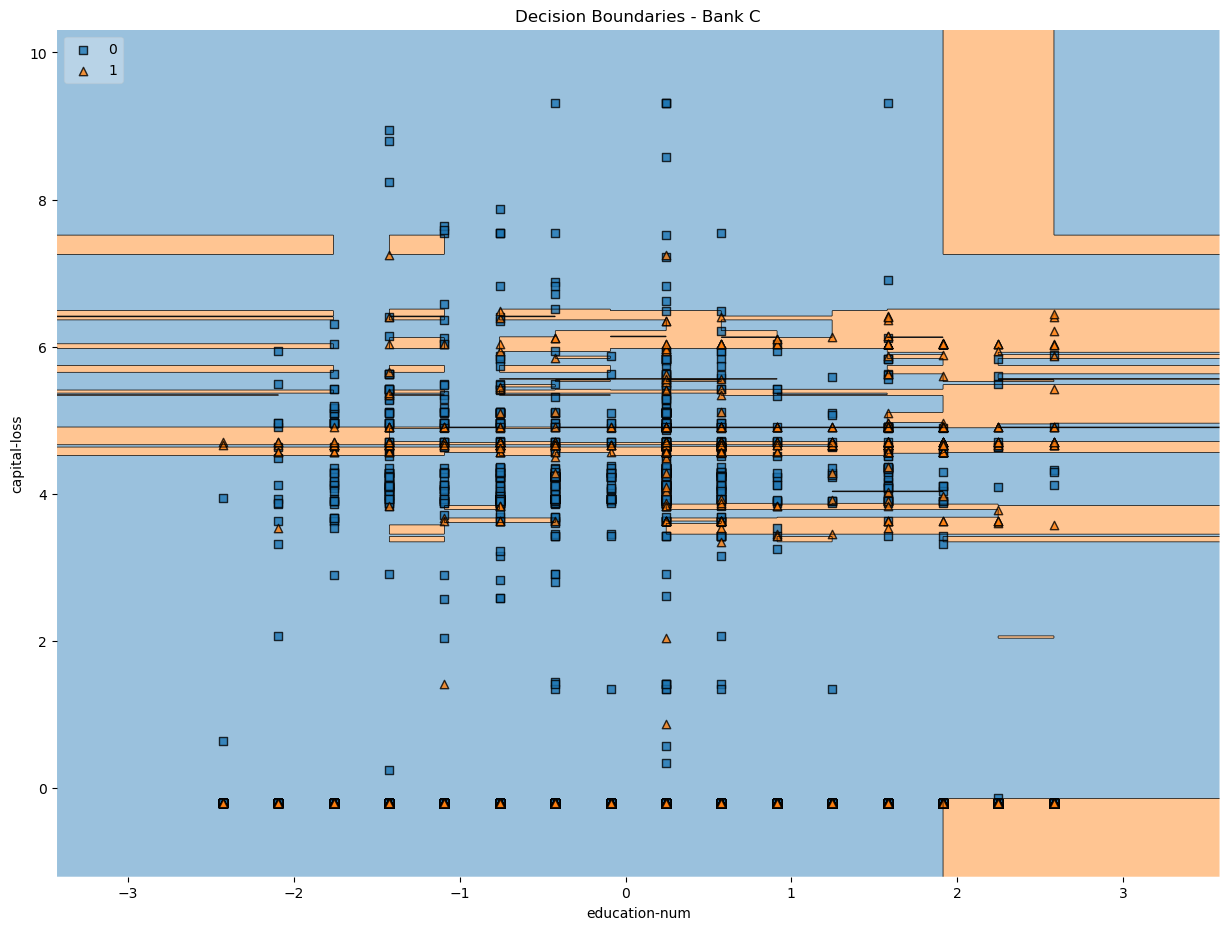

In [26]:
top_features = ["education-num", "capital-loss"]
X_subset = X_test[top_features].to_numpy()
y_subset = y_test.to_numpy().astype(int)

model_subset = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model_subset.fit(X_subset, y_subset)


plt.figure(figsize=(15, 11))
plot_decision_regions(X_subset, y_subset, clf=model_subset, legend=2)


plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title("Decision Boundaries - Bank C")
plt.show()


In [113]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

best_params = None
best_score = 0

for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    model = xgb.XGBClassifier(**param_dict, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train_sub, y_train_sub)

    score = model.score(X_val, y_val)
    
    if score > best_score:
        best_score = score
        best_params = param_dict

print("Best Parameters:", best_params)
print("Best Validation Score:", best_score)


Best Parameters: {'n_estimators': 200, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 1.0}
Best Validation Score: 0.8967399267399268


Classification Report for Bank C:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94     28291
         1.0       0.77      0.52      0.62      5833

    accuracy                           0.89     34124
   macro avg       0.84      0.75      0.78     34124
weighted avg       0.88      0.89      0.88     34124

Confusion Matrix for Bank C:


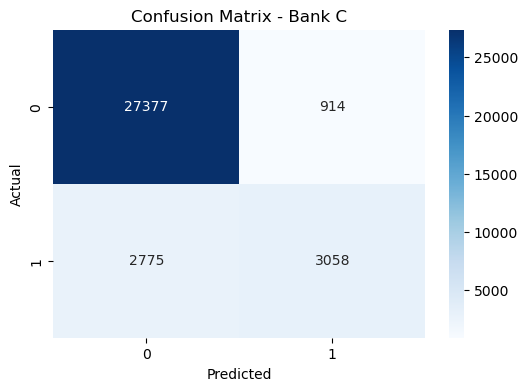

📌 ROC-AUC Score for Bank C: 0.9204


In [112]:
best_params = {
    "n_estimators": 200,
    "learning_rate": 0.2,
    "max_depth": 3,
    "subsample": 1.0,
    "colsample_bytree": 1.0
}

model_bank_c = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
model_bank_c.fit(X_train, y_train)

# Vorhersagen
y_pred = model_bank_c.predict(X_test)
y_pred_proba = model_bank_c.predict_proba(X_test)[:, 1]

print("Classification Report for Bank C:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix for Bank C:")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Bank C")
plt.show()


auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"📌 ROC-AUC Score for Bank C: {auc_score:.4f}")


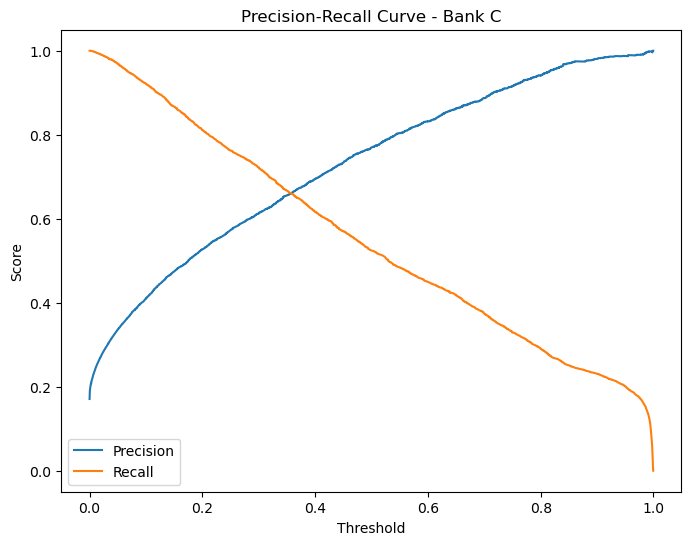

In [36]:
y_scores = model_bank_c.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve - Bank C")
plt.legend()
plt.show()


Classification Report with optimized threshold for Bank C:
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93     28291
         1.0       0.64      0.67      0.66      5833

    accuracy                           0.88     34124
   macro avg       0.79      0.80      0.79     34124
weighted avg       0.88      0.88      0.88     34124



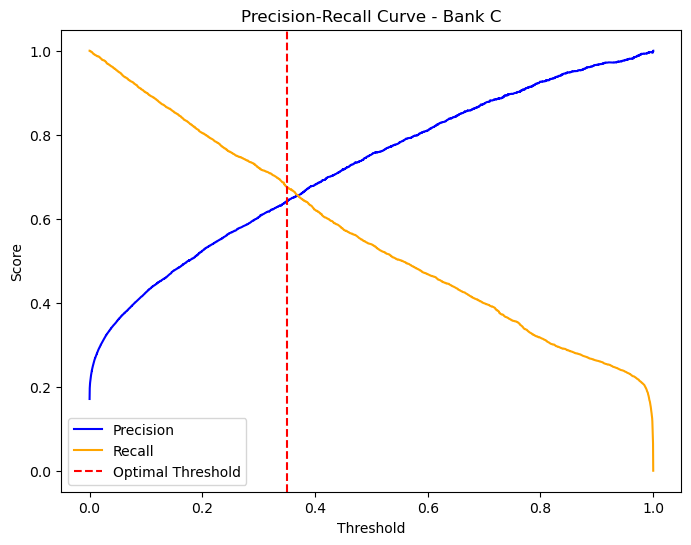

In [111]:
y_scores = model.predict_proba(X_test)[:, 1]

optimal_threshold = 0.35
y_pred = (y_scores >= optimal_threshold).astype(int)

print("Classification Report with optimized threshold for Bank C:")
print(classification_report(y_test, y_pred))

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="orange")
plt.axvline(optimal_threshold, color="red", linestyle="dashed", label="Optimal Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Curve - Bank C")
plt.legend()
plt.show()


In [40]:
def apply_smote(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [41]:
apply_smote(X_train, y_train)

(             age  education-num  capital-gain  capital-loss  hours-per-week  \
 0       0.870504       0.577881     -0.122490     -0.210492        0.099821   
 1       0.369431      -1.092282     -0.122490     -0.210492        0.099821   
 2       0.181529       0.243849     -0.122490     -0.210492        0.099821   
 3       1.434211       0.243849     -0.122490     -0.210492        0.099821   
 4      -0.507446       0.243849      1.088883     -0.210492        1.554516   
 ...          ...            ...           ...           ...             ...   
 226327  0.008193       0.243849     -0.122490     -0.210492        1.554516   
 226328  1.606412       1.914012     -0.122490     -0.210492        0.099821   
 226329  1.447203       0.629849     16.476043     -0.210492       -0.589807   
 226330  1.463906       0.243849     -0.122490     -0.210492        0.827169   
 226331  0.557333       1.579980     -0.122490     -0.210492        0.654889   
 
         education_11th  education_12t

In [42]:
file_smote = "../wandb_exports/runs/eight_run_w_SMOTE.csv"  
file_no_smote = "../wandb_exports/runs/ninth_run_wo_SMOTE.csv"

df_smote = pd.read_csv(file_smote)
df_no_smote = pd.read_csv(file_no_smote)


                    Name     State Notes  User  Tags  \
0  BankA_fl_run-tu030i0g   crashed     -   NaN   NaN   
1  BankC_fl_run-o6096kuf   crashed     -   NaN   NaN   
2  BankB_fl_run-cfi8gnj3  finished     -   NaN   NaN   
3  BankA_fl_run-jx28dta6  finished     -   NaN   NaN   
4  BankC_fl_run-jy39cbnu  finished     -   NaN   NaN   

                    Created  Runtime  Sweep  colsample_bytree eval_metric  \
0  2025-01-29T19:04:29.000Z        0    NaN            0.8631       aucpr   
1  2025-01-29T19:04:28.000Z        0    NaN            0.8631       aucpr   
2  2025-01-29T19:04:24.000Z        3    NaN            0.8631       aucpr   
3  2025-01-29T19:04:22.000Z        6    NaN            0.8631       aucpr   
4  2025-01-29T19:04:22.000Z        5    NaN            0.8631       aucpr   

   ...  Optimal Threshold  Precision  Recall  Round Train Size  \
0  ...                NaN        NaN     NaN    NaN        NaN   
1  ...                NaN        NaN     NaN    NaN        NaN   
2 

In [102]:
# 📊 1️⃣ Boxplot der Metriken für beide Runs (AUC, Recall, Precision, F1-Score)
metrics = ["AUC", "Recall", "Precision", "F1-Score", "LogLoss"]

df_smote["SMOTE"] = "With SMOTE"
df_no_smote["SMOTE"] = "Without SMOTE"
df_combined = pd.concat([df_smote, df_no_smote])


In [103]:
df_combined.reset_index(level=0, inplace=True)

In [104]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 224 non-null    int64  
 1   Name                  224 non-null    object 
 2   State                 224 non-null    object 
 3   Notes                 224 non-null    object 
 4   User                  0 non-null      float64
 5   Tags                  0 non-null      float64
 6   Created               224 non-null    object 
 7   Runtime               224 non-null    int64  
 8   Sweep                 0 non-null      float64
 9   colsample_bytree      224 non-null    float64
 10  eval_metric           224 non-null    object 
 11  learning_rate         224 non-null    float64
 12  max_depth             224 non-null    int64  
 13  min_child_weight      224 non-null    int64  
 14  n_estimators          224 non-null    int64  
 15  objective             2

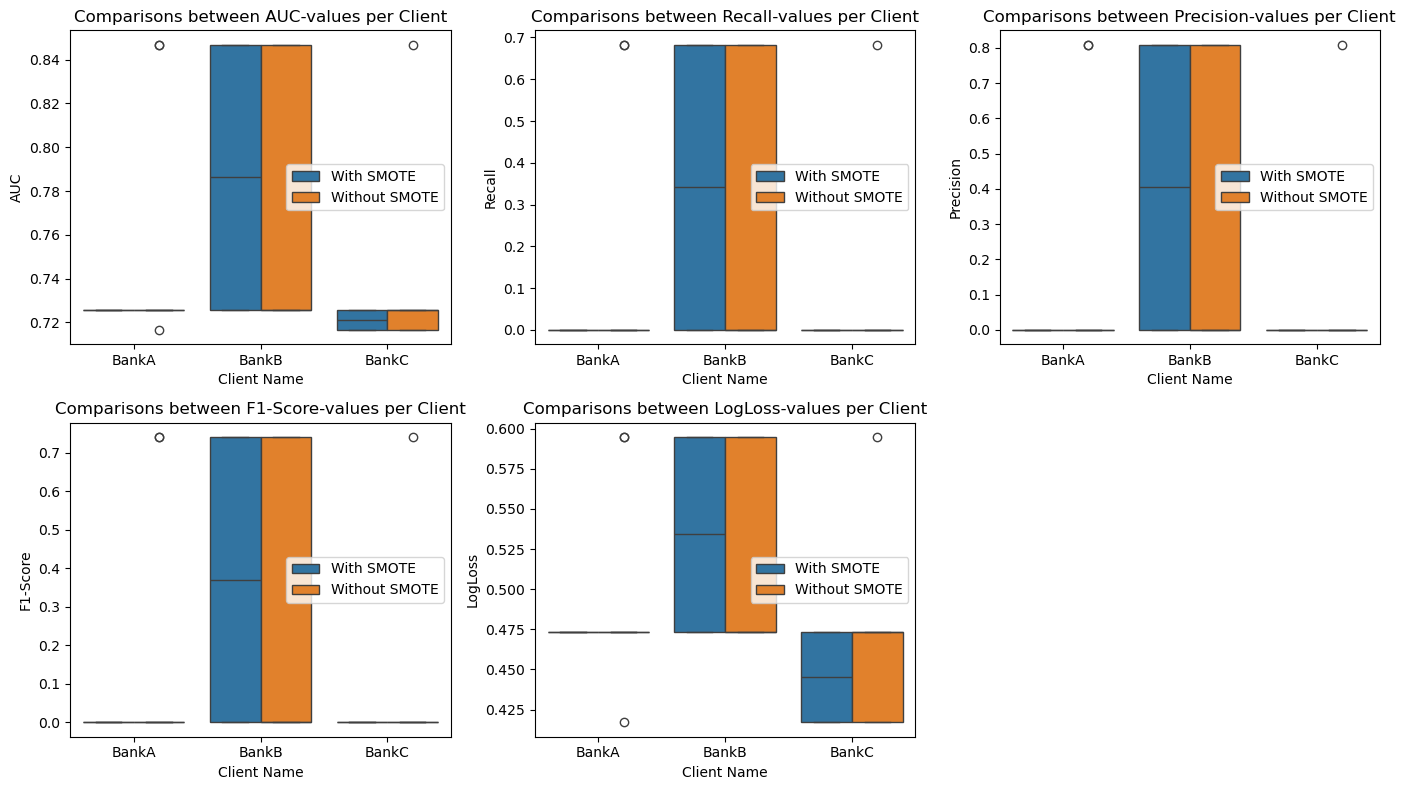

In [109]:
plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="Client Name", y=metric, hue="SMOTE", data=df_combined)
    plt.title(f"Comparisons between {metric}-values per Client")
    plt.legend(loc="best")
plt.tight_layout()
plt.show()



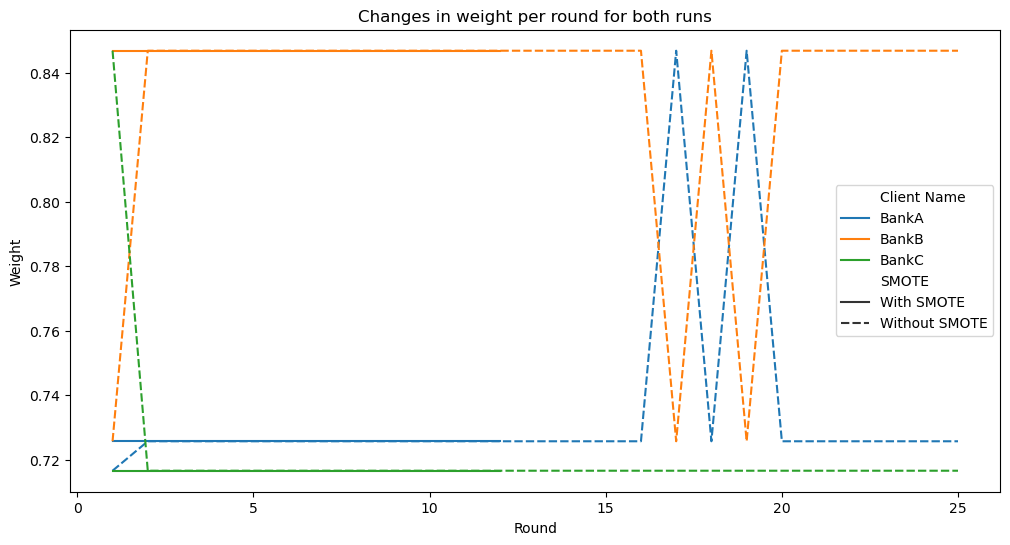

In [106]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="Round", y="AUC", hue="Client Name", style="SMOTE", data=df_combined)
plt.title("Changes in weight per round for both runs")
plt.xlabel("Round")
plt.ylabel("Weight")
plt.legend(loc="best")
plt.show()



In [83]:
print(f"df_smote:\n {df_smote[metrics].isna().sum()}")


df_smote:
 AUC          38
Recall       38
Precision    38
F1-Score     38
LogLoss      38
dtype: int64


In [84]:
print(f"df_no_smote:\n {df_no_smote[metrics].isna().sum()}")


df_no_smote:
 AUC          75
Recall       75
Precision    75
F1-Score     75
LogLoss      75
dtype: int64


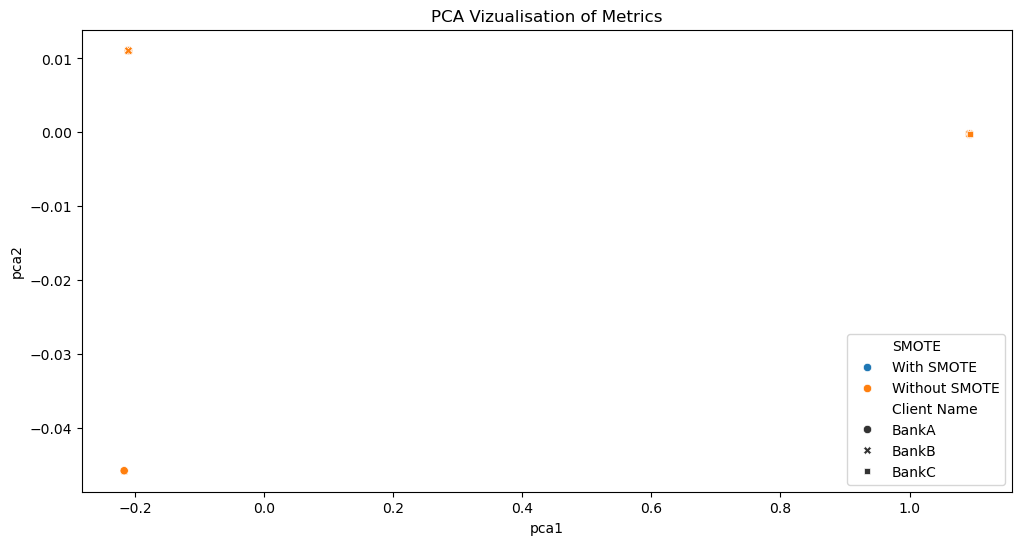

In [107]:
pca = PCA(n_components=2)
df_smote["pca1"], df_smote["pca2"] = pca.fit_transform(df_smote[metrics]).T
df_no_smote["pca1"], df_no_smote["pca2"] = pca.transform(df_no_smote[metrics]).T

plt.figure(figsize=(12, 6))
sns.scatterplot(x="pca1", y="pca2", hue="SMOTE", style="Client Name", data=df_combined)
plt.title("PCA Vizualisation of Metrics")
plt.legend(loc="best")
plt.show()



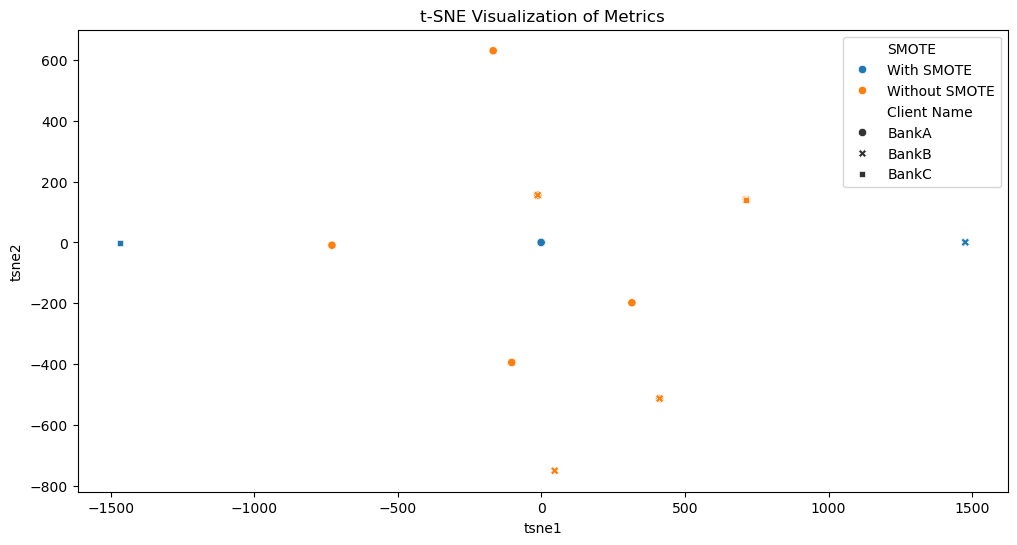

In [108]:
tsne = TSNE(n_components=2, random_state=42)
df_smote["tsne1"], df_smote["tsne2"] = tsne.fit_transform(df_smote[metrics]).T
df_no_smote["tsne1"], df_no_smote["tsne2"] = tsne.fit_transform(df_no_smote[metrics]).T

plt.figure(figsize=(12, 6))
sns.scatterplot(x="tsne1", y="tsne2", hue="SMOTE", style="Client Name", data=df_combined)
plt.title("t-SNE Visualization of Metrics")
plt.legend(loc="best")
plt.show()

